## 1. Imports and Configuration


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import shutil
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
import torchvision.transforms as transforms
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set paths to the dataset (for Kaggle)
base_dir = '/kaggle/input/deeplense-lensefinding-dataset'
train_lens_dir = os.path.join(base_dir, 'train_lenses')
train_nonlens_dir = os.path.join(base_dir, 'train_nonlenses')
test_lens_dir = os.path.join(base_dir, 'test_lenses')
test_nonlens_dir = os.path.join(base_dir, 'test_nonlenses')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 2. Exploratory Data Analysis



--- Dataset Statistics ---
Training set: 1730 lenses, 28675 non-lenses
Testing set: 195 lenses, 19455 non-lenses
Class imbalance (training): 1:16.58
Class imbalance (testing): 1:99.77

--- Class Weights ---
Non-lens weight: 0.5302
Lens weight: 8.7876
Positive class weight for BCEWithLogitsLoss: 16.5751

--- Sample Visualization ---


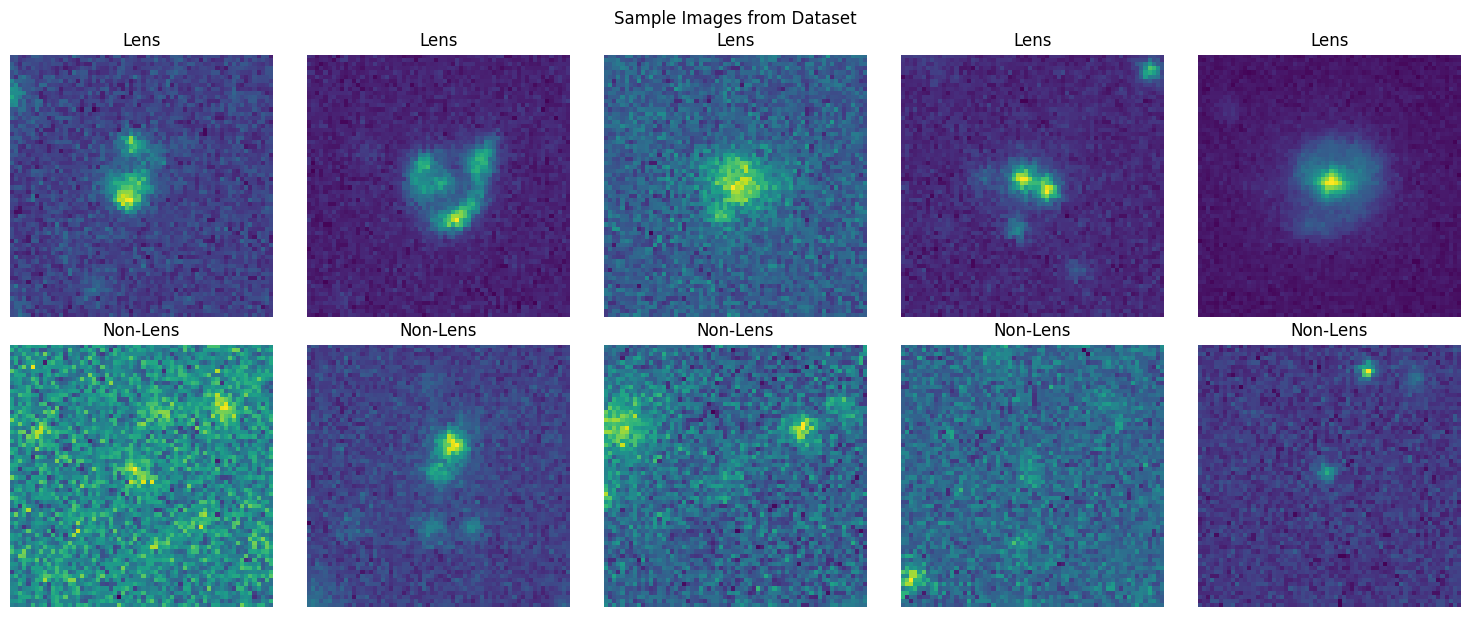

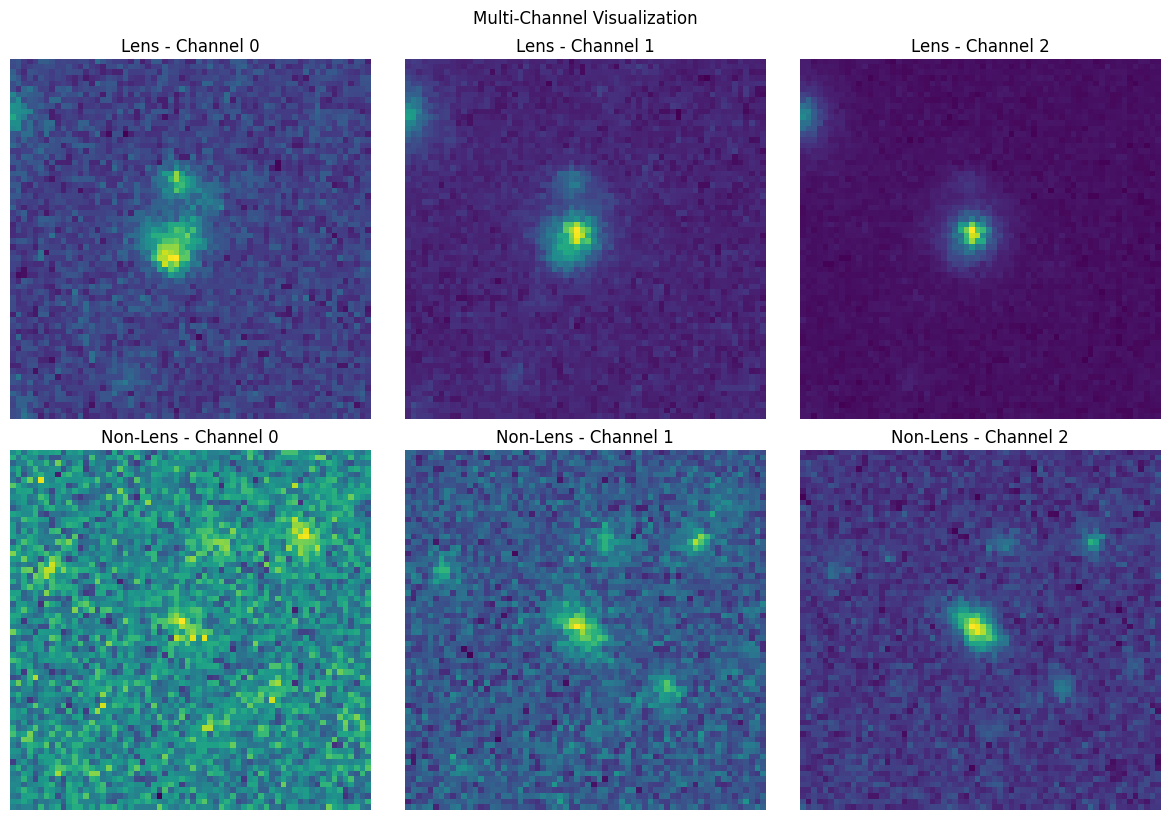


--- Detailed Image Analysis ---

--- Image Statistics Summary ---
            min                                       max       ...       std  \
          count mean  std  min  25%  50%  75%  max  count mean  ...       75%   
type                                                            ...             
Lens      100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  100.0  1.0  ...  0.112426   
Non-Lens  100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  100.0  1.0  ...  0.143869   

                   median                                                    \
               max  count      mean       std       min       25%       50%   
type                                                                          
Lens      0.351257  100.0  0.065580  0.041883  0.007614  0.035121  0.055420   
Non-Lens  0.201373  100.0  0.174827  0.102234  0.001609  0.086766  0.185685   

                              
               75%       max  
type                          
Lens      0.088677  0.199890  
Non-Len

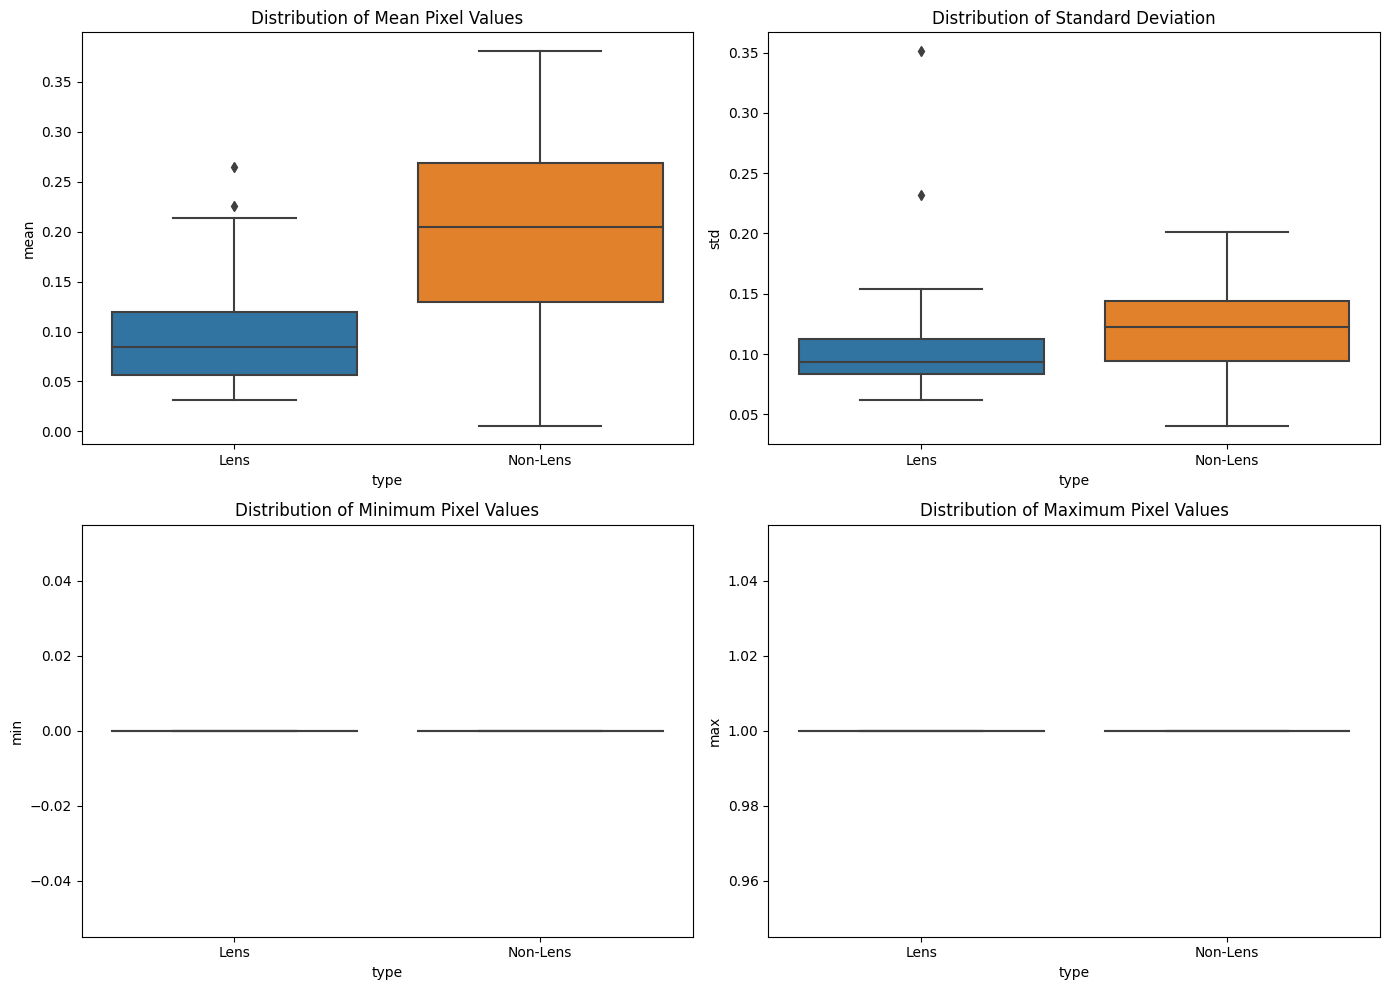

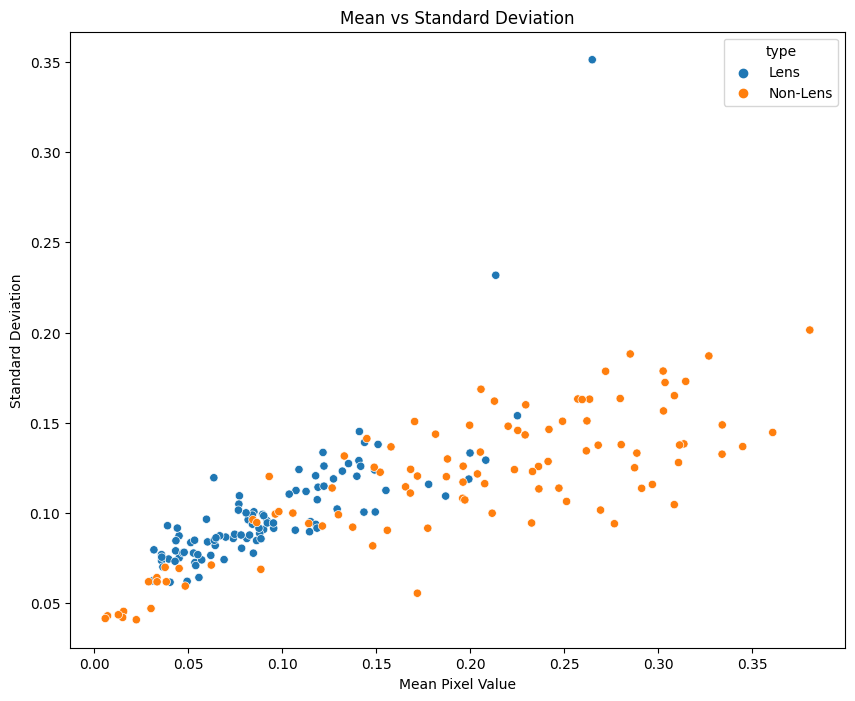

In [2]:
# Count files in each directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if name.endswith('.npy')])

# Get dataset statistics
train_lens_count = count_files(train_lens_dir)
train_nonlens_count = count_files(train_nonlens_dir)
test_lens_count = count_files(test_lens_dir)
test_nonlens_count = count_files(test_nonlens_dir)

# Print dataset statistics
print("\n--- Dataset Statistics ---")
print(f"Training set: {train_lens_count} lenses, {train_nonlens_count} non-lenses")
print(f"Testing set: {test_lens_count} lenses, {test_nonlens_count} non-lenses")
print(f"Class imbalance (training): 1:{train_nonlens_count/train_lens_count:.2f}")
print(f"Class imbalance (testing): 1:{test_nonlens_count/test_lens_count:.2f}")

# Calculate class weights for BCE loss
total_train_samples = train_lens_count + train_nonlens_count
weight_for_0 = total_train_samples / (2 * train_nonlens_count)  # Weight for non-lens class
weight_for_1 = total_train_samples / (2 * train_lens_count)     # Weight for lens class
pos_weight = torch.tensor([train_nonlens_count / train_lens_count])

print(f"\n--- Class Weights ---")
print(f"Non-lens weight: {weight_for_0:.4f}")
print(f"Lens weight: {weight_for_1:.4f}")
print(f"Positive class weight for BCEWithLogitsLoss: {pos_weight.item():.4f}")

# Function to visualize sample images
def visualize_samples(lens_dir, nonlens_dir, num_samples=5):
    # Load lens samples
    lens_files = random.sample([os.path.join(lens_dir, f) for f in os.listdir(lens_dir) 
                                if f.endswith('.npy')], num_samples)
    lens_images = [np.load(f) for f in lens_files]
    
    # Load non-lens samples
    nonlens_files = random.sample([os.path.join(nonlens_dir, f) for f in os.listdir(nonlens_dir) 
                                  if f.endswith('.npy')], num_samples)
    nonlens_images = [np.load(f) for f in nonlens_files]
    
    # Create figure for visualization
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    # Plot lens samples
    for i, img in enumerate(lens_images):
        # For visualization, use the first channel and normalize
        vis_img = img[0]
        vis_img = (vis_img - np.min(vis_img)) / (np.max(vis_img) - np.min(vis_img))
        axes[0, i].imshow(vis_img, cmap='viridis')
        axes[0, i].set_title('Lens')
        axes[0, i].axis('off')
    
    # Plot non-lens samples
    for i, img in enumerate(nonlens_images):
        vis_img = img[0]
        vis_img = (vis_img - np.min(vis_img)) / (np.max(vis_img) - np.min(vis_img))
        axes[1, i].imshow(vis_img, cmap='viridis')
        axes[1, i].set_title('Non-Lens')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Images from Dataset', y=1.02)
    plt.show()
    
    # Multi-channel visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    # Show each channel of a lens image
    for i in range(3):
        vis_img = lens_images[0][i]
        vis_img = (vis_img - np.min(vis_img)) / (np.max(vis_img) - np.min(vis_img))
        axes[0, i].imshow(vis_img, cmap='viridis')
        axes[0, i].set_title(f'Lens - Channel {i}')
        axes[0, i].axis('off')
    
    # Show each channel of a non-lens image
    for i in range(3):
        vis_img = nonlens_images[0][i]
        vis_img = (vis_img - np.min(vis_img)) / (np.max(vis_img) - np.min(vis_img))
        axes[1, i].imshow(vis_img, cmap='viridis')
        axes[1, i].set_title(f'Non-Lens - Channel {i}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Multi-Channel Visualization', y=1.02)
    plt.show()

# Run visualization
print("\n--- Sample Visualization ---")
visualize_samples(train_lens_dir, train_nonlens_dir)

# Analyze image statistics
def analyze_image_stats(lens_dir, nonlens_dir, num_samples=100):
    # Sample files
    lens_files = random.sample([os.path.join(lens_dir, f) for f in os.listdir(lens_dir) 
                                if f.endswith('.npy')], 
                              min(num_samples, len(os.listdir(lens_dir))))
    nonlens_files = random.sample([os.path.join(nonlens_dir, f) for f in os.listdir(nonlens_dir) 
                                  if f.endswith('.npy')], 
                                 min(num_samples, len(os.listdir(nonlens_dir))))
    
    # Initialize stats list
    stats = []
    
    # Analyze lens samples
    for f in lens_files:
        img = np.load(f)
        stats.append({
            'type': 'Lens',
            'min': np.min(img),
            'max': np.max(img),
            'mean': np.mean(img),
            'std': np.std(img),
            'median': np.median(img),
            'shape': img.shape
        })
    
    # Analyze non-lens samples
    for f in nonlens_files:
        img = np.load(f)
        stats.append({
            'type': 'Non-Lens',
            'min': np.min(img),
            'max': np.max(img),
            'mean': np.mean(img),
            'std': np.std(img),
            'median': np.median(img),
            'shape': img.shape
        })
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(stats)
    
    # Print summary statistics
    print("\n--- Image Statistics Summary ---")
    print(stats_df.groupby('type').describe())
    
    # Visualize distributions
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot mean distribution
    sns.boxplot(x='type', y='mean', data=stats_df, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Mean Pixel Values')
    
    # Plot std distribution
    sns.boxplot(x='type', y='std', data=stats_df, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Standard Deviation')
    
    # Plot min/max distributions
    sns.boxplot(x='type', y='min', data=stats_df, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Minimum Pixel Values')
    
    sns.boxplot(x='type', y='max', data=stats_df, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Maximum Pixel Values')
    
    plt.tight_layout()
    plt.show()
    
    # Plot mean vs std
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='mean', y='std', hue='type', data=stats_df)
    plt.title('Mean vs Standard Deviation')
    plt.xlabel('Mean Pixel Value')
    plt.ylabel('Standard Deviation')
    plt.show()
    
    return stats_df

# Run detailed image analysis
print("\n--- Detailed Image Analysis ---")
stats_df = analyze_image_stats(train_lens_dir, train_nonlens_dir)


## 3. Channel Statictics & Data Processing

In [3]:
def preprocess_data_and_get_statistics(train_lens_dir, train_nonlens_dir, augment_factor=10, output_dir='processed_data', seed=42):
    """
    Preprocess training data and calculate channel statistics on the processed data.
    
    Steps:
    1. Augment minority class (lenses) by specified factor
    2. Reduce majority class (non-lenses) [i kept unchanged]
    3. Calculate channel statistics on the processed training data
    
    Args:
        train_lens_dir: Directory with original lens samples
        train_nonlens_dir: Directory with original non-lens samples
        augment_factor: How many times to multiply lens samples (2 or 3)
        output_dir: Directory to save processed data
        seed: Random seed for reproducibility
    
    Returns:
        Tuple of (processed_lens_dir, processed_nonlens_dir, means, stds)
    """
    random.seed(seed)
    np.random.seed(seed)
    
    # Create output directories
    processed_lens_dir = os.path.join(output_dir, 'processed_lenses')
    processed_nonlens_dir = os.path.join(output_dir, 'processed_nonlenses')
    
    os.makedirs(processed_lens_dir, exist_ok=True)
    os.makedirs(processed_nonlens_dir, exist_ok=True)
    
    # Get all lens files
    lens_files = [os.path.join(train_lens_dir, f) for f in os.listdir(train_lens_dir) if f.endswith('.npy')]
    print(f"Processing {len(lens_files)} lens files...")
    
    # Define comprehensive augmentation pipeline
    aug_pipeline = A.Compose([
        # Spatial transforms
        A.OneOf([
            A.HorizontalFlip(p=0.8),
            A.VerticalFlip(p=0.8),
            A.Transpose(p=0.5),  # 90-degree rotation with flipping
        ], p=0.8),
        
        # Rotations
        A.OneOf([
            A.RandomRotate90(p=0.8),
            A.Rotate(limit=30, p=0.8),
            A.ShiftScaleRotate(p=0.8, rotate_limit=45, shift_limit=0.15, scale_limit=0.15),
        ], p=0.8),
        
        # Blur and noise
        A.OneOf([
            A.GaussianBlur(blur_limit=3, p=0.5),
        ], p=0.5),
        
        # Color and contrast
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
        ], p=0.7),
    ])
    
    # Copy original lens files
    for i, file_path in enumerate(tqdm(lens_files, desc="Copying original lens files")):
        img_name = os.path.basename(file_path)
        shutil.copy(file_path, os.path.join(processed_lens_dir, img_name))
    
    # Generate augmented lens files
    for aug_idx in range(augment_factor - 1):  # -1 because we already copied the originals
        for i, file_path in enumerate(tqdm(lens_files, desc=f"Generating augmented set {aug_idx+1}")):
            # Load image
            img = np.load(file_path)
            
            # Convert from [C, H, W] to [H, W, C] for albumentations
            img_hwc = np.transpose(img, (1, 2, 0))
            
            # Apply augmentation
            aug_img_hwc = aug_pipeline(image=img_hwc)['image']
            
            # Convert back to [C, H, W]
            aug_img = np.transpose(aug_img_hwc, (2, 0, 1))
            
            # Save augmented image
            img_basename = os.path.basename(file_path)
            aug_name = f"aug{aug_idx+1}_{img_basename}"
            np.save(os.path.join(processed_lens_dir, aug_name), aug_img)
    
    # Get all non-lens files
    nonlens_files = [os.path.join(train_nonlens_dir, f) for f in os.listdir(train_nonlens_dir) if f.endswith('.npy')]
    print(f"Processing {len(nonlens_files)} non-lens files...")
    
    # Randomly select 4.48th of non-lens files
    selected_nonlens = random.sample(nonlens_files, int(len(nonlens_files) / 1))

    
    # Copy selected non-lens files
    for file_path in tqdm(selected_nonlens, desc="Copying selected non-lens files"):
        img_name = os.path.basename(file_path)
        shutil.copy(file_path, os.path.join(processed_nonlens_dir, img_name))
    
    print(f"Data preprocessing complete:")
    print(f"Original lens files: {len(lens_files)}")
    print(f"Total augmented lens files: {len(lens_files) * augment_factor}")
    print(f"Original non-lens files: {len(nonlens_files)}")
    print(f"Selected non-lens files: {len(selected_nonlens)}")
    
    # Now calculate channel statistics on the processed training data
    print("\n--- Calculating Channel Statistics on Processed Training Data ---")
    
    # Get all processed files
    processed_lens_files = [os.path.join(processed_lens_dir, f) for f in os.listdir(processed_lens_dir) if f.endswith('.npy')]
    processed_nonlens_files = [os.path.join(processed_nonlens_dir, f) for f in os.listdir(processed_nonlens_dir) if f.endswith('.npy')]
    
    all_processed_files = processed_lens_files + processed_nonlens_files
    total_files = len(all_processed_files)
    
    print(f"Processing {total_files} files for channel statistics...")
    
    # Initialize arrays to store channel sums
    channel_sums = np.zeros(3)
    channel_squared_sums = np.zeros(3)
    total_pixels = 0
    
    # Process all files
    for file in tqdm(all_processed_files, desc="Calculating statistics"):
        img = np.load(file)  # Shape: (3, 64, 64)
        total_pixels += img.shape[1] * img.shape[2]  # Pixels per channel
        
        # Sum each channel separately
        for c in range(3):
            channel_sums[c] += np.sum(img[c])
            channel_squared_sums[c] += np.sum(img[c]**2)
    
    # Calculate means and standard deviations
    means = channel_sums / (total_pixels * len(all_processed_files))
    stds = np.sqrt((channel_squared_sums / (total_pixels * len(all_processed_files))) - means**2)
    
    print(f"Channel means: {means}")
    print(f"Channel stds: {stds}")
    
    return processed_lens_dir, processed_nonlens_dir, means, stds

## 4. Dataset Class Implementation

In [4]:
class LensDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        """
        Custom dataset for gravitational lens detection.
        
        Args:
            files: List of file paths to images
            labels: List of labels corresponding to files
            transform: Transforms to apply to all images
        """
        self.files = files
        self.labels = labels
        self.transform = transform
        
        # Verify data integrity
        assert len(self.files) == len(self.labels), "Files and labels must have the same length"
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        
        # Load image (numpy array with shape [3, 64, 64])
        image = np.load(img_path)
        
        # Convert to tensor
        image = torch.from_numpy(image).float()
        
        # Apply transforms (including normalization)
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transformations using pre-calculated means and stds
def get_transforms(means, stds):
    """Returns normalization transforms for images."""
    return transforms.Compose([
        transforms.Normalize(mean=means, std=stds)
    ])

## 5. Train-Validation Split, Test 

In [5]:
def create_datasets(processed_lens_dir, processed_nonlens_dir, test_lens_dir, test_nonlens_dir, means, stds, val_split=0.1):
    """
    Creates training, validation, and test datasets.
    
    Args:
        processed_lens_dir: Directory containing processed lens samples
        processed_nonlens_dir: Directory containing processed non-lens samples
        test_lens_dir: Directory containing test lens samples
        test_nonlens_dir: Directory containing test non-lens samples
        means: Channel means for normalization
        stds: Channel standard deviations for normalization
        val_split: Fraction of processed data to use for validation
        
    Returns:
        train_dataset, val_dataset, test_dataset
    """
    # Create normalization transform using the statistics from augmented training data
    transform = get_transforms(means, stds)
    
    # Get all processed files
    processed_lens_files = [os.path.join(processed_lens_dir, f) for f in os.listdir(processed_lens_dir) if f.endswith('.npy')]
    processed_nonlens_files = [os.path.join(processed_nonlens_dir, f) for f in os.listdir(processed_nonlens_dir) if f.endswith('.npy')]
    
    # Shuffle files (important for good split)
    random.shuffle(processed_lens_files)
    random.shuffle(processed_nonlens_files)
    
    # Split lens files - 10% for validation, 90% for training
    val_lens_count = int(len(processed_lens_files) * val_split)
    val_lens_files = processed_lens_files[:val_lens_count]
    train_lens_files = processed_lens_files[val_lens_count:]
    
    # Split non-lens files - 10% for validation, 90% for training
    val_nonlens_count = int(len(processed_nonlens_files) * val_split)
    val_nonlens_files = processed_nonlens_files[:val_nonlens_count]
    train_nonlens_files = processed_nonlens_files[val_nonlens_count:]
    
    # Create training dataset
    train_files = train_lens_files + train_nonlens_files
    train_labels = [1] * len(train_lens_files) + [0] * len(train_nonlens_files)
    
    # Shuffle train data while keeping labels aligned
    train_data = list(zip(train_files, train_labels))
    random.shuffle(train_data)
    train_files, train_labels = zip(*train_data)
    
    train_dataset = LensDataset(
        files=train_files,
        labels=train_labels,
        transform=transform
    )
    
    # Create validation dataset
    val_files = val_lens_files + val_nonlens_files
    val_labels = [1] * len(val_lens_files) + [0] * len(val_nonlens_files)
    
    # Shuffle validation data while keeping labels aligned
    val_data = list(zip(val_files, val_labels))
    random.shuffle(val_data)
    val_files, val_labels = zip(*val_data)
    
    val_dataset = LensDataset(
        files=val_files,
        labels=val_labels,
        transform=transform
    )
    
    # Get original test files
    test_lens_files = [os.path.join(test_lens_dir, f) for f in os.listdir(test_lens_dir) if f.endswith('.npy')]
    test_nonlens_files = [os.path.join(test_nonlens_dir, f) for f in os.listdir(test_nonlens_dir) if f.endswith('.npy')]
    
    # Create test dataset with the same normalization
    test_files = test_lens_files + test_nonlens_files
    test_labels = [1] * len(test_lens_files) + [0] * len(test_nonlens_files)
    
    test_dataset = LensDataset(
        files=test_files,
        labels=test_labels,
        transform=transform  # Use same normalization as training
    )
    
    # Print dataset statistics
    lens_ratio_train = len(train_lens_files) / len(train_files)
    lens_ratio_val = len(val_lens_files) / len(val_files)
    lens_ratio_test = len(test_lens_files) / len(test_files)
    
    print(f"Dataset Creation Complete:")
    print(f"Training: {len(train_dataset)} samples ({len(train_lens_files)} lens [{lens_ratio_train:.1%}], {len(train_nonlens_files)} non-lens)")
    print(f"Validation: {len(val_dataset)} samples ({len(val_lens_files)} lens [{lens_ratio_val:.1%}], {len(val_nonlens_files)} non-lens)")
    print(f"Test: {len(test_dataset)} samples ({len(test_lens_files)} lens [{lens_ratio_test:.1%}], {len(test_nonlens_files)} non-lens)")
    
    return train_dataset, val_dataset, test_dataset


## 6. Data Loading and Preprocessing


In [6]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32, num_workers=4):
    """
    Creates DataLoader objects for the training, validation, and test datasets.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
        batch_size: Batch size for training
        num_workers: Number of worker processes for data loading
        
    Returns:
        train_loader, val_loader, test_loader
    """
    # Since we've already balanced the dataset through preprocessing,
    # we can use a regular shuffled DataLoader for training
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the training data
        num_workers=num_workers,
        pin_memory=True  # Speeds up data transfer to GPU
    )
    
    # No need to shuffle validation and test sets
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    # Print DataLoader information
    print("\n--- DataLoader Creation ---")
    print(f"Train loader: {len(train_loader)} batches, {len(train_dataset)} samples")
    print(f"Validation loader: {len(val_loader)} batches, {len(val_dataset)} samples")
    print(f"Test loader: {len(test_loader)} batches, {len(test_dataset)} samples")
    
    # Calculate class distribution in training data
    train_labels = [label for _, label in train_dataset]
    train_lens_count = sum(train_labels)
    train_nonlens_count = len(train_labels) - train_lens_count
    
    print(f"\nClass distribution in training data:")
    print(f"  Lens samples: {train_lens_count} ({train_lens_count/len(train_dataset):.1%})")
    print(f"  Non-lens samples: {train_nonlens_count} ({train_nonlens_count/len(train_dataset):.1%})")
    print(f"  Ratio (non-lens:lens): {train_nonlens_count/train_lens_count:.2f}:1")
    
    # Calculate batch distribution (important to verify balance is maintained in batches)
    first_batch_samples = next(iter(train_loader))
    first_batch_labels = first_batch_samples[1].numpy()
    first_batch_lens_count = np.sum(first_batch_labels == 1)
    first_batch_nonlens_count = np.sum(first_batch_labels == 0)
    
    print(f"\nExample batch distribution:")
    print(f"  Lens samples: {first_batch_lens_count} ({first_batch_lens_count/len(first_batch_labels):.1%})")
    print(f"  Non-lens samples: {first_batch_nonlens_count} ({first_batch_nonlens_count/len(first_batch_labels):.1%})")
    
    return train_loader, val_loader, test_loader


## 7. Model Architecture Implementation


In [7]:
# Implementation for EfficientNet-B1 model
class EfficientNetB1Model(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetB1Model, self).__init__()
        # Create EfficientNet-B1 model
        self.model = timm.create_model(
            'tf_efficientnet_b1', 
            pretrained=False,
            num_classes=num_classes
        )
        
    def forward(self, x):
        return self.model(x)

# Implementation for EfficientNet-B2 model
class EfficientNetB2Model(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetB2Model, self).__init__()
        # Create EfficientNet-B2 model
        self.model = timm.create_model(
            'tf_efficientnet_b2', 
            pretrained=False,
            num_classes=num_classes
        )
        
    def forward(self, x):
        return self.model(x)

# Implementation for ResNet18 model
class ResNet18Model(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18Model, self).__init__()
        # Create ResNet18 model
        self.model = timm.create_model(
            'resnet18', 
            pretrained=False,
            num_classes=num_classes
        )
        
    def forward(self, x):
        return self.model(x)

# Implementation for MobileViT-v2-100 model
class MobileViTV2Model(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileViTV2Model, self).__init__()
        # Create MobileViT-v2-100 model
        self.model = timm.create_model(
            'mobilevitv2_100', 
            pretrained=False,
            num_classes=num_classes
        )
        
    def forward(self, x):
        return self.model(x)

# Implementation for Ensemble model (EfficientNet-B1 + EfficientNet-B2)
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        # Get logits from all models
        outputs = [model(x) for model in self.models]
        # Average the logits
        return torch.mean(torch.stack(outputs), dim=0)


## 8. Training Functions

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=15, patience=5, save_path='best_model.pth'):
    """
    Trains a model for binary classification of gravitational lenses.
    
    Args:
        model: Model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of epochs to train for
        patience: Patience for early stopping
        save_path: Path to save best model
        
    Returns:
        History dictionary containing training and validation metrics
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': []
    }
    
    # Initialize best validation metrics
    best_val_loss = float('inf')
    best_val_auc = 0.0
    no_improve_epochs = 0
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Training")
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Convert labels to one-hot encoding for BCE loss
            labels_one_hot = F.one_hot(labels, num_classes=2).float()
            
            # Calculate loss with one-hot encoded labels
            loss = criterion(outputs, labels_one_hot)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update training loss
            train_loss += loss.item() * inputs.size(0)
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_probs = []
        
        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Validation")
        
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Convert labels to one-hot encoding for BCE loss
                labels_one_hot = F.one_hot(labels, num_classes=2).float()
                
                # Calculate loss with one-hot encoded labels
                loss = criterion(outputs, labels_one_hot)
                
                # Update validation loss
                val_loss += loss.item() * inputs.size(0)
                
                # Convert logits to probabilities
                probs = torch.softmax(outputs, dim=1)[:, 1]
                
                # Store labels and predictions
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
                val_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate average validation loss and AUC
        val_loss = val_loss / len(val_loader.dataset)
        val_auc = roc_auc_score(all_labels, all_probs)
        
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        
        # Update learning rate based on validation metrics
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Print epoch statistics
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
        
        # Check if validation metrics improved
        improved = False
        
        if val_auc > best_val_auc:
            improved = True
            best_val_auc = val_auc
            # Save best model
            torch.save(model.state_dict(), save_path)
            print(f"Validation AUC improved to {best_val_auc:.4f}. Model saved to {save_path}")
        
        if val_loss < best_val_loss:
            improved = True
            best_val_loss = val_loss
        
        # Early stopping check
        if not improved:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs")
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        else:
            no_improve_epochs = 0
    
    print(f"Best validation AUC: {best_val_auc:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load(save_path))
    
    return history


## 9. Evaluation Function


In [9]:
def evaluate_model(model, test_loader, save_plots=True, plots_dir='plots'):
    """
    Evaluates a trained model on test data.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        save_plots: Whether to save plots
        plots_dir: Directory to save plots
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Create directory for plots if it doesn't exist
    if save_plots and not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and labels
    all_labels = []
    all_probs = []
    all_preds = []
    
    # Progress bar for testing
    test_pbar = tqdm(test_loader, desc="Testing")
    
    with torch.no_grad():
        for inputs, labels in test_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Convert logits to probabilities and predictions
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)
            
            # Store labels, probabilities, and predictions
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc = roc_auc_score(all_labels, all_probs)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate classification report
    report = classification_report(all_labels, all_preds, target_names=['Non-Lens', 'Lens'], output_dict=True)
    
    # Print evaluation metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"AUC Score: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-Lens', 'Lens']))
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Lens Detection')
    plt.legend(loc='lower right')
    
    if save_plots:
        plt.savefig(os.path.join(plots_dir, 'roc_curve.png'), dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Lens', 'Lens'], 
                yticklabels=['Non-Lens', 'Lens'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    if save_plots:
        plt.savefig(os.path.join(plots_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Find optimal threshold
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Apply optimal threshold
    optimal_preds = (np.array(all_probs) >= optimal_threshold).astype(int)
    optimal_cm = confusion_matrix(all_labels, optimal_preds)
    optimal_report = classification_report(all_labels, optimal_preds, 
                                          target_names=['Non-Lens', 'Lens'], 
                                          output_dict=True)
    
    print(f"\n--- Optimal Threshold Analysis ---")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print("\nConfusion Matrix with Optimal Threshold:")
    print(optimal_cm)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(all_labels, optimal_preds, target_names=['Non-Lens', 'Lens']))
    
    # Plot confusion matrix with optimal threshold
    plt.figure(figsize=(8, 6))
    sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Lens', 'Lens'], 
                yticklabels=['Non-Lens', 'Lens'])
    plt.xlabel('Predicted (Optimal Threshold)')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.4f})')
    
    if save_plots:
        plt.savefig(os.path.join(plots_dir, 'confusion_matrix_optimal.png'), dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Return all metrics
    return {
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'confusion_matrix': cm,
        'classification_report': report,
        'optimal_threshold': optimal_threshold,
        'optimal_confusion_matrix': optimal_cm,
        'optimal_classification_report': optimal_report
    }

def visualize_training_history(history, save_plot=True, plots_dir='plots'):
    """
    Visualizes training history.
    
    Args:
        history: History dictionary from train_model
        save_plot: Whether to save the plot
        plots_dir: Directory to save the plot
    """
    # Create directory for plots if it doesn't exist
    if save_plot and not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot validation AUC
    ax2.plot(history['val_auc'], label='Validation AUC', color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.set_title('Validation AUC')
    ax2.set_ylim([0, 1])
    ax2.grid(True)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(os.path.join(plots_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
    
    plt.show()


## 10. Main Execution


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:230: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


Using positive class weight: 16.5751
Processing 1730 lens files...


Generating augmented set 9: 100%|██████████| 1730/1730 [00:03<00:00, 496.10it/s]


Processing 28675 non-lens files...


Copying selected non-lens files: 100%|██████████| 28675/28675 [00:56<00:00, 503.45it/s]


Data preprocessing complete:
Original lens files: 1730
Total augmented lens files: 17300
Original non-lens files: 28675
Selected non-lens files: 28675

--- Calculating Channel Statistics on Processed Training Data ---
Processing 45975 files for channel statistics...


Calculating statistics: 100%|██████████| 45975/45975 [00:08<00:00, 5508.37it/s]


Channel means: [5.04787122e-06 3.42576924e-06 1.94553866e-06]
Channel stds: [0.00134542 0.0010112  0.0006589 ]
Dataset Creation Complete:
Training: 41378 samples (15570 lens [37.6%], 25808 non-lens)
Validation: 4597 samples (1730 lens [37.6%], 2867 non-lens)
Test: 19650 samples (195 lens [1.0%], 19455 non-lens)

--- DataLoader Creation ---
Train loader: 1294 batches, 41378 samples
Validation loader: 144 batches, 4597 samples
Test loader: 615 batches, 19650 samples

Class distribution in training data:
  Lens samples: 15570 (37.6%)
  Non-lens samples: 25808 (62.4%)
  Ratio (non-lens:lens): 1.66:1

Example batch distribution:
  Lens samples: 10 (31.2%)
  Non-lens samples: 22 (68.8%)

--- Training EfficientNet-B1 Model ---


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.71it/s, loss=1.71]


Train Loss: 2.0590, Val Loss: 4.1073, Val AUC: 0.9103
Validation AUC improved to 0.9103. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 2/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.98it/s, loss=1.5] 


Train Loss: 1.5776, Val Loss: 4.5145, Val AUC: 0.9305
Validation AUC improved to 0.9305. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 3/15


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.44it/s, loss=1.34] 


Train Loss: 1.2705, Val Loss: 3.5529, Val AUC: 0.9445
Validation AUC improved to 0.9445. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 4/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 50.13it/s, loss=1.2]  


Train Loss: 1.1178, Val Loss: 2.7096, Val AUC: 0.9423

Epoch 5/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 49.97it/s, loss=1.03] 


Train Loss: 0.9971, Val Loss: 1.4525, Val AUC: 0.9507
Validation AUC improved to 0.9507. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 6/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 51.55it/s, loss=1.04] 


Train Loss: 0.8327, Val Loss: 3.1299, Val AUC: 0.9668
Validation AUC improved to 0.9668. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 7/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.66it/s, loss=0.837]


Train Loss: 0.7743, Val Loss: 1.1424, Val AUC: 0.9707
Validation AUC improved to 0.9707. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 8/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.07it/s, loss=0.659]


Train Loss: 0.6889, Val Loss: 0.9220, Val AUC: 0.9732
Validation AUC improved to 0.9732. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 9/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 49.18it/s, loss=0.612]


Train Loss: 0.6062, Val Loss: 1.4529, Val AUC: 0.9709
No improvement for 1 epochs

Epoch 10/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 49.03it/s, loss=0.392]


Train Loss: 0.5608, Val Loss: 1.2046, Val AUC: 0.9775
Validation AUC improved to 0.9775. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 11/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.57it/s, loss=0.314]


Train Loss: 0.4873, Val Loss: 0.7355, Val AUC: 0.9812
Validation AUC improved to 0.9812. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 12/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.62it/s, loss=0.262]


Train Loss: 0.4181, Val Loss: 0.5731, Val AUC: 0.9836
Validation AUC improved to 0.9836. Model saved to lens_detection_results/best_efficientnet_b1_model.pth

Epoch 13/15


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.87it/s, loss=0.995]


Train Loss: 0.3948, Val Loss: 1.3841, Val AUC: 0.9756
No improvement for 1 epochs

Epoch 14/15


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.02it/s, loss=0.26] 


Train Loss: 0.3611, Val Loss: 0.7296, Val AUC: 0.9816
No improvement for 2 epochs

Epoch 15/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 49.39it/s, loss=0.274]
<ipython-input-8-b53490d3c3e9>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

Train Loss: 0.3352, Val Loss: 0.6070, Val AUC: 0.9821
No improvement for 3 epochs
Best validation AUC: 0.9836


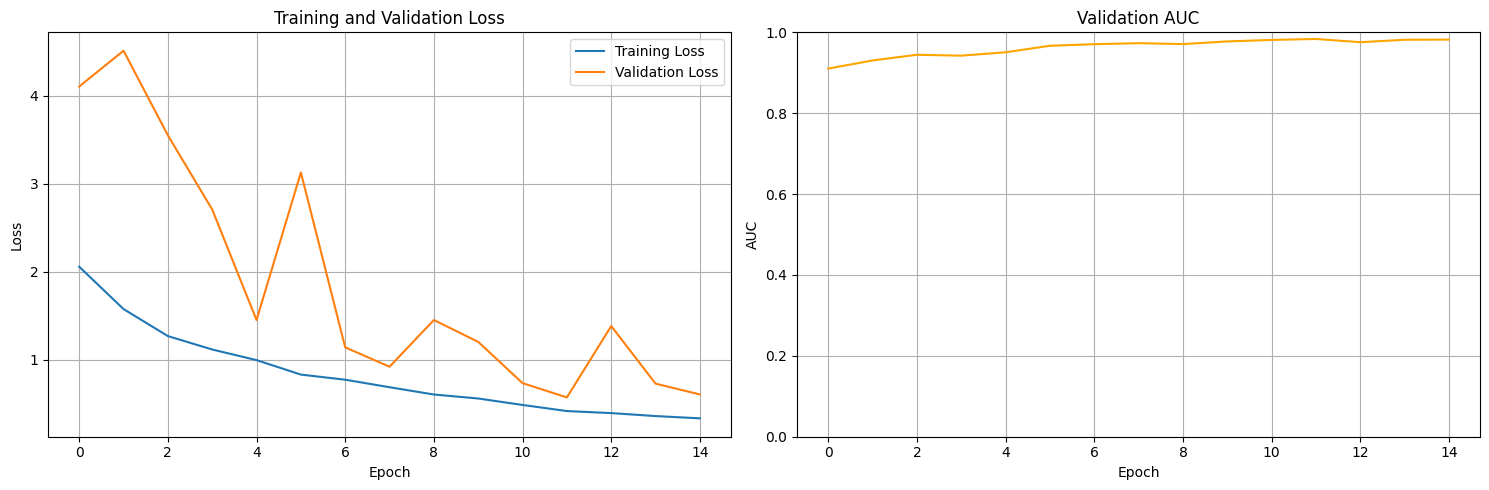


--- Evaluating EfficientNet-B1 Model ---


Testing: 100%|██████████| 615/615 [00:35<00:00, 17.49it/s]



--- Evaluation Metrics ---
AUC Score: 0.9421

Confusion Matrix:
[[18537   918]
 [   60   135]]

Classification Report:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.95      0.97     19455
        Lens       0.13      0.69      0.22       195

    accuracy                           0.95     19650
   macro avg       0.56      0.82      0.60     19650
weighted avg       0.99      0.95      0.97     19650



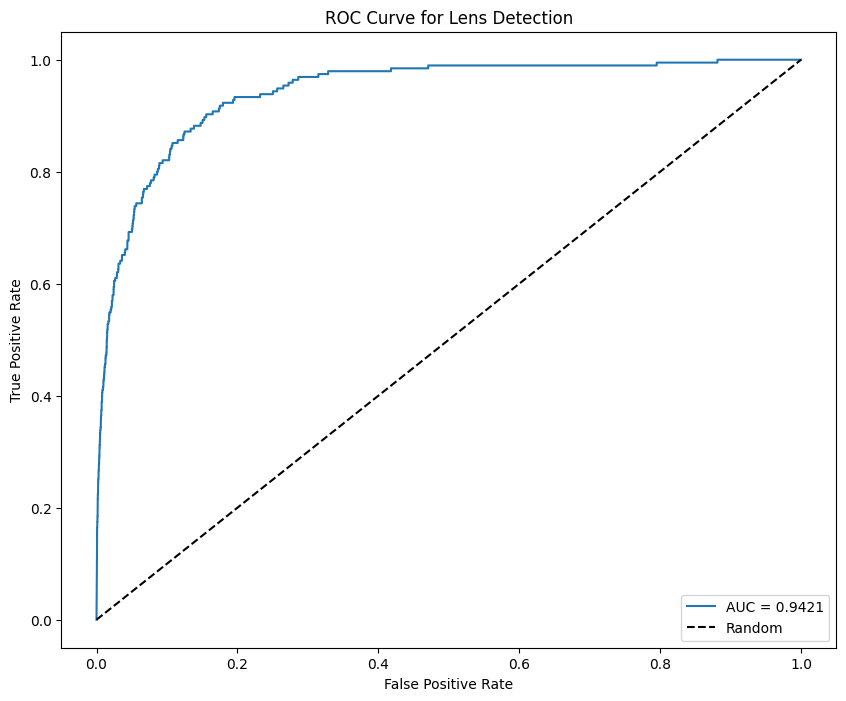

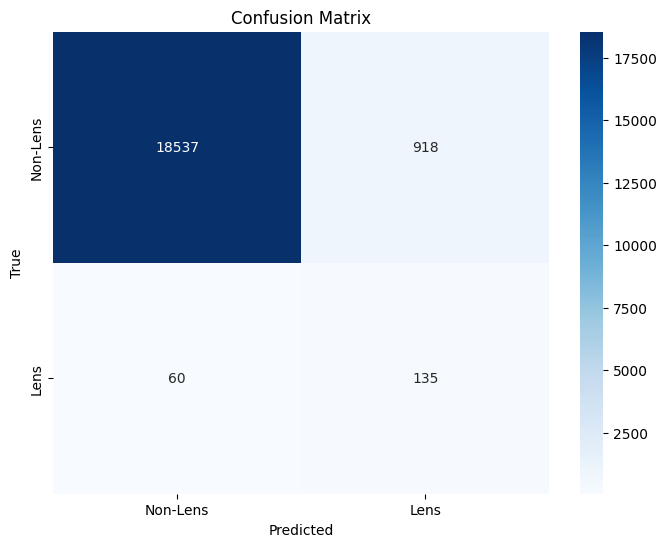


--- Optimal Threshold Analysis ---
Optimal Threshold: 0.0564

Confusion Matrix with Optimal Threshold:
[[17025  2430]
 [   25   170]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.88      0.93     19455
        Lens       0.07      0.87      0.12       195

    accuracy                           0.88     19650
   macro avg       0.53      0.87      0.53     19650
weighted avg       0.99      0.88      0.92     19650



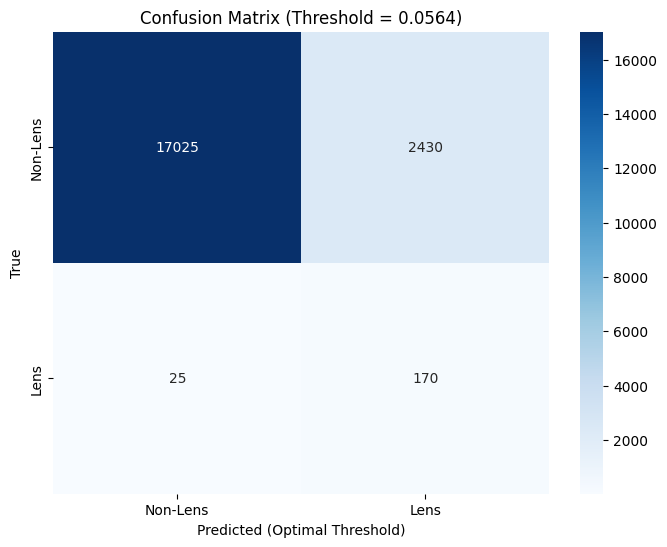

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Training EfficientNet-B2 Model ---

Epoch 1/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 50.00it/s, loss=1.46]


Train Loss: 1.9819, Val Loss: 7.3384, Val AUC: 0.9194
Validation AUC improved to 0.9194. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 2/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.46it/s, loss=1.38]


Train Loss: 1.4243, Val Loss: 3.1987, Val AUC: 0.9265
Validation AUC improved to 0.9265. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 3/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 49.20it/s, loss=3]   


Train Loss: 1.2179, Val Loss: 2.9300, Val AUC: 0.9426
Validation AUC improved to 0.9426. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 4/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.66it/s, loss=1.25]


Train Loss: 1.0374, Val Loss: 2.1214, Val AUC: 0.9492
Validation AUC improved to 0.9492. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 5/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.16it/s, loss=0.96] 


Train Loss: 0.9140, Val Loss: 1.1692, Val AUC: 0.9546
Validation AUC improved to 0.9546. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 6/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.75it/s, loss=1.37] 


Train Loss: 0.8066, Val Loss: 1.6072, Val AUC: 0.9652
Validation AUC improved to 0.9652. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 7/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 50.30it/s, loss=0.851]


Train Loss: 0.7110, Val Loss: 0.9056, Val AUC: 0.9681
Validation AUC improved to 0.9681. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 8/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 49.68it/s, loss=3.24] 


Train Loss: 0.6486, Val Loss: 4.5741, Val AUC: 0.9197
No improvement for 1 epochs

Epoch 9/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 51.77it/s, loss=0.626]


Train Loss: 0.5982, Val Loss: 0.8813, Val AUC: 0.9747
Validation AUC improved to 0.9747. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 10/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.87it/s, loss=0.684]


Train Loss: 0.5109, Val Loss: 0.8917, Val AUC: 0.9787
Validation AUC improved to 0.9787. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 11/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 49.16it/s, loss=0.413]


Train Loss: 0.4591, Val Loss: 1.1119, Val AUC: 0.9784
No improvement for 1 epochs

Epoch 12/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.83it/s, loss=0.471]


Train Loss: 0.4402, Val Loss: 2.3935, Val AUC: 0.9776
No improvement for 2 epochs

Epoch 13/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 48.63it/s, loss=0.392]


Train Loss: 0.3900, Val Loss: 0.6432, Val AUC: 0.9835
Validation AUC improved to 0.9835. Model saved to lens_detection_results/best_efficientnet_b2_model.pth

Epoch 14/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 50.25it/s, loss=0.316]


Train Loss: 0.3607, Val Loss: 1.1281, Val AUC: 0.9754
No improvement for 1 epochs

Epoch 15/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 50.45it/s, loss=0.307]
<ipython-input-8-b53490d3c3e9>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

Train Loss: 0.3124, Val Loss: 0.6179, Val AUC: 0.9834
Best validation AUC: 0.9835


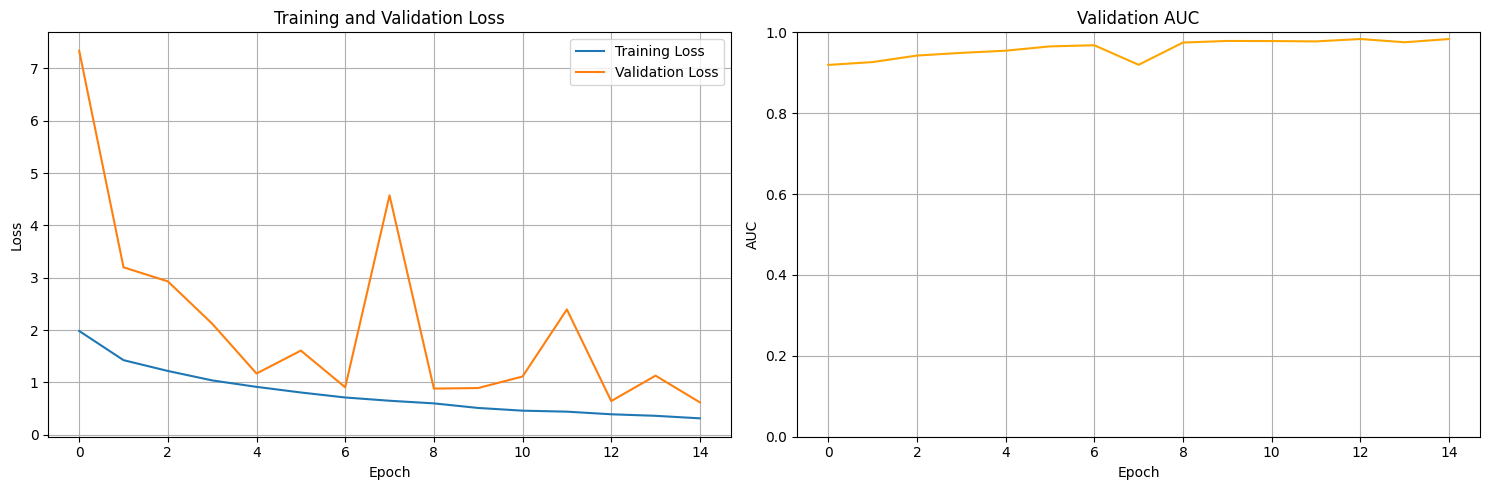


--- Evaluating EfficientNet-B2 Model ---


Testing: 100%|██████████| 615/615 [00:13<00:00, 47.25it/s]



--- Evaluation Metrics ---
AUC Score: 0.9350

Confusion Matrix:
[[17791  1664]
 [   49   146]]

Classification Report:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.91      0.95     19455
        Lens       0.08      0.75      0.15       195

    accuracy                           0.91     19650
   macro avg       0.54      0.83      0.55     19650
weighted avg       0.99      0.91      0.95     19650



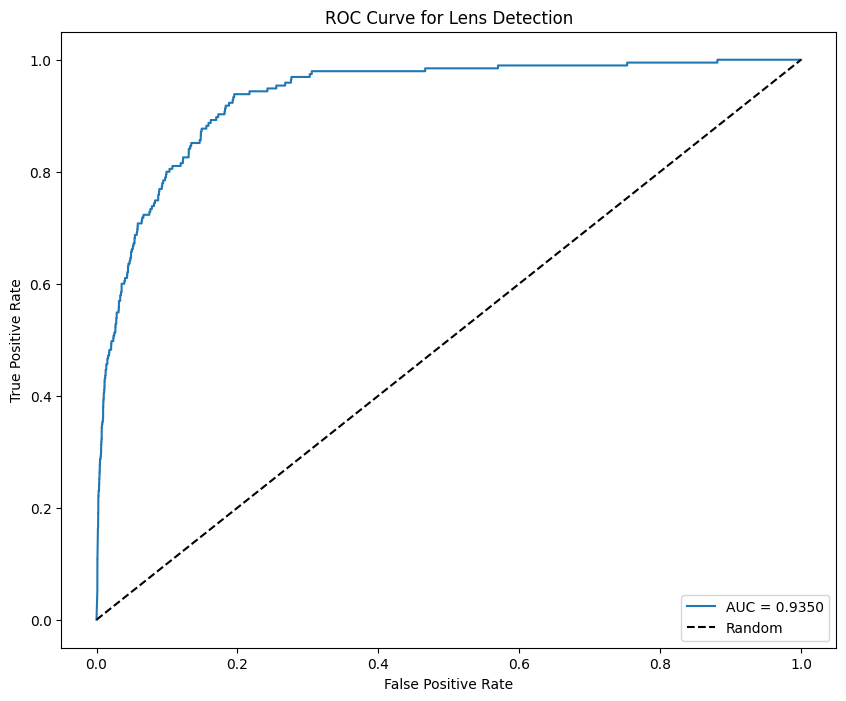

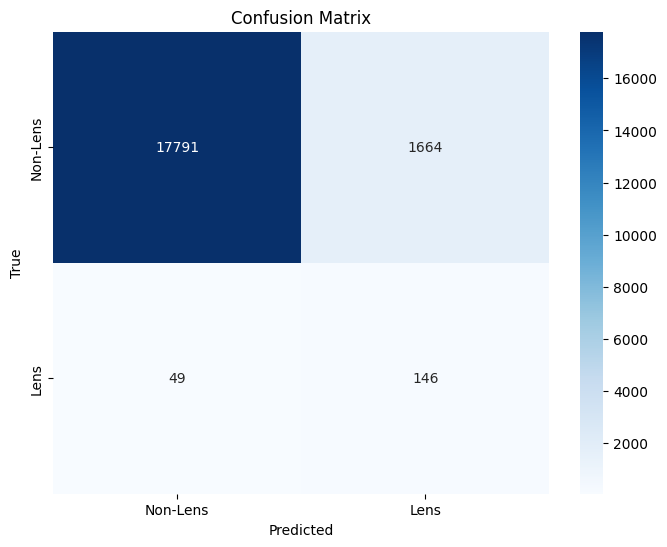


--- Optimal Threshold Analysis ---
Optimal Threshold: 0.0500

Confusion Matrix with Optimal Threshold:
[[15652  3803]
 [   12   183]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.80      0.89     19455
        Lens       0.05      0.94      0.09       195

    accuracy                           0.81     19650
   macro avg       0.52      0.87      0.49     19650
weighted avg       0.99      0.81      0.88     19650



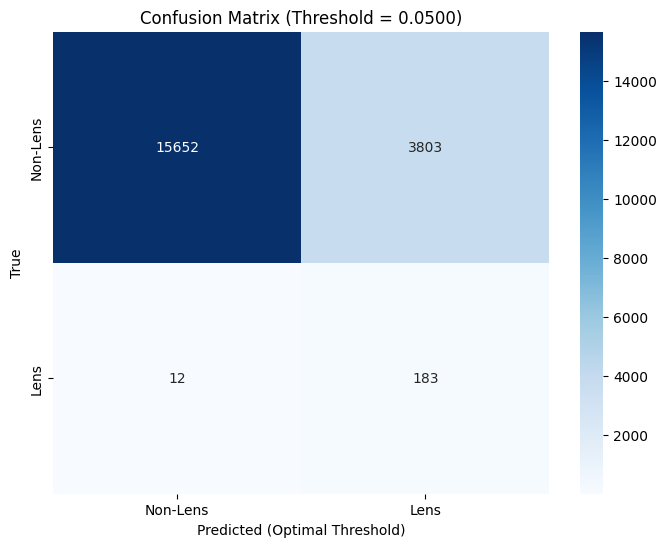

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Training ResNet18 Model ---

Epoch 1/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 97.60it/s, loss=0.313] 


Train Loss: 0.8156, Val Loss: 0.4609, Val AUC: 0.9888
Validation AUC improved to 0.9888. Model saved to lens_detection_results/best_resnet18_model.pth

Epoch 2/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 96.51it/s, loss=0.181]  


Train Loss: 0.4149, Val Loss: 0.3327, Val AUC: 0.9940
Validation AUC improved to 0.9940. Model saved to lens_detection_results/best_resnet18_model.pth

Epoch 3/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 95.51it/s, loss=0.253]  


Train Loss: 0.3304, Val Loss: 0.4366, Val AUC: 0.9918
No improvement for 1 epochs

Epoch 4/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 96.94it/s, loss=0.101]  


Train Loss: 0.2782, Val Loss: 0.3126, Val AUC: 0.9963
Validation AUC improved to 0.9963. Model saved to lens_detection_results/best_resnet18_model.pth

Epoch 5/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 93.73it/s, loss=0.139]  


Train Loss: 0.2443, Val Loss: 0.3255, Val AUC: 0.9946
No improvement for 1 epochs

Epoch 6/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 95.72it/s, loss=0.0701] 


Train Loss: 0.2104, Val Loss: 0.2602, Val AUC: 0.9962

Epoch 7/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 94.47it/s, loss=0.0722] 


Train Loss: 0.1854, Val Loss: 0.3073, Val AUC: 0.9957
No improvement for 1 epochs

Epoch 8/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 95.03it/s, loss=0.0493] 


Train Loss: 0.1765, Val Loss: 0.3175, Val AUC: 0.9958
No improvement for 2 epochs

Epoch 9/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 93.83it/s, loss=0.0545]  


Train Loss: 0.1461, Val Loss: 0.3155, Val AUC: 0.9961
No improvement for 3 epochs

Epoch 10/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 96.88it/s, loss=0.079]   


Train Loss: 0.1444, Val Loss: 0.2849, Val AUC: 0.9965
Validation AUC improved to 0.9965. Model saved to lens_detection_results/best_resnet18_model.pth

Epoch 11/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 88.08it/s, loss=0.0591]   


Train Loss: 0.0771, Val Loss: 0.2528, Val AUC: 0.9977
Validation AUC improved to 0.9977. Model saved to lens_detection_results/best_resnet18_model.pth

Epoch 12/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 95.98it/s, loss=0.049]   


Train Loss: 0.0641, Val Loss: 0.2889, Val AUC: 0.9973
No improvement for 1 epochs

Epoch 13/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 97.03it/s, loss=0.0172]   


Train Loss: 0.0557, Val Loss: 0.3856, Val AUC: 0.9973
No improvement for 2 epochs

Epoch 14/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 96.14it/s, loss=0.0133]   


Train Loss: 0.0506, Val Loss: 0.3892, Val AUC: 0.9971
No improvement for 3 epochs

Epoch 15/15


Validation: 100%|██████████| 144/144 [00:01<00:00, 97.21it/s, loss=0.0204]  
<ipython-input-8-b53490d3c3e9>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

Train Loss: 0.0471, Val Loss: 0.3426, Val AUC: 0.9975
No improvement for 4 epochs
Best validation AUC: 0.9977


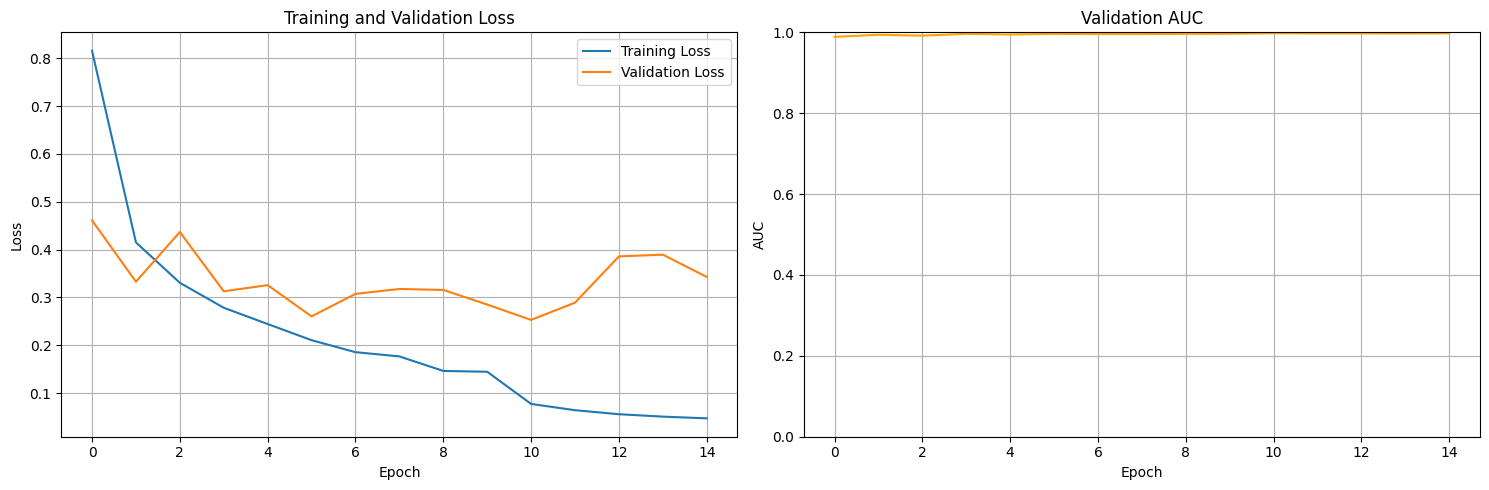


--- Evaluating ResNet18 Model ---


Testing: 100%|██████████| 615/615 [00:06<00:00, 96.04it/s] 



--- Evaluation Metrics ---
AUC Score: 0.9818

Confusion Matrix:
[[18974   481]
 [   29   166]]

Classification Report:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.98      0.99     19455
        Lens       0.26      0.85      0.39       195

    accuracy                           0.97     19650
   macro avg       0.63      0.91      0.69     19650
weighted avg       0.99      0.97      0.98     19650



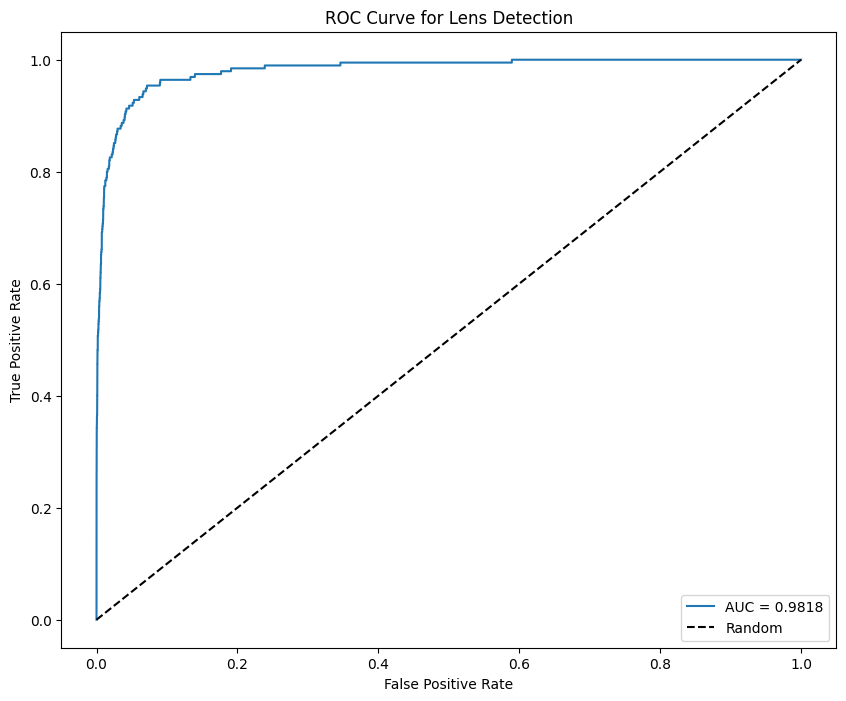

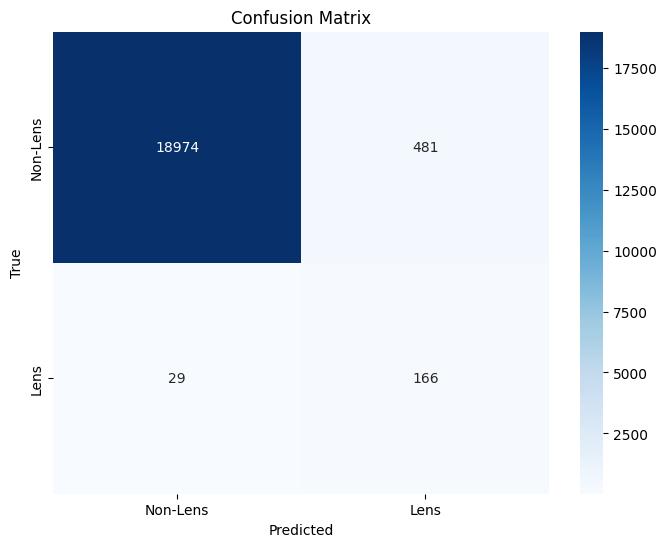


--- Optimal Threshold Analysis ---
Optimal Threshold: 0.0021

Confusion Matrix with Optimal Threshold:
[[18061  1394]
 [    9   186]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.93      0.96     19455
        Lens       0.12      0.95      0.21       195

    accuracy                           0.93     19650
   macro avg       0.56      0.94      0.59     19650
weighted avg       0.99      0.93      0.96     19650



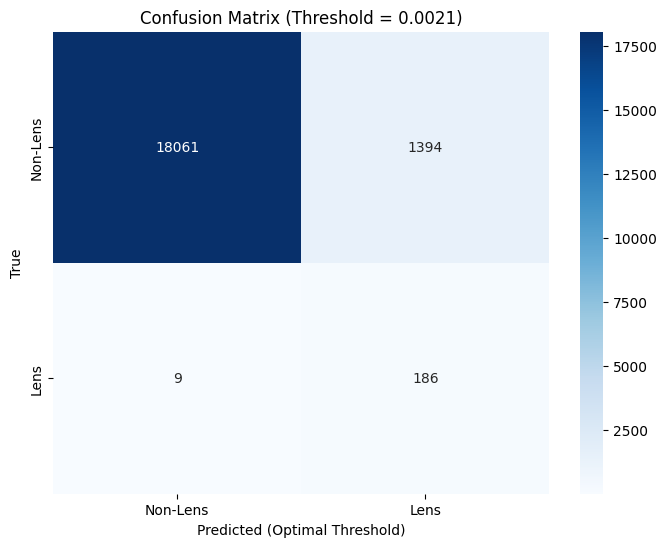

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Training MobileViTV2 Model ---

Epoch 1/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 55.59it/s, loss=0.682]


Train Loss: 1.2483, Val Loss: 0.6784, Val AUC: 0.9744
Validation AUC improved to 0.9744. Model saved to lens_detection_results/best_mobilevit_model.pth

Epoch 2/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 56.33it/s, loss=0.564]


Train Loss: 0.7108, Val Loss: 0.6699, Val AUC: 0.9775
Validation AUC improved to 0.9775. Model saved to lens_detection_results/best_mobilevit_model.pth

Epoch 3/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 57.59it/s, loss=0.26]  


Train Loss: 0.5971, Val Loss: 0.5165, Val AUC: 0.9852
Validation AUC improved to 0.9852. Model saved to lens_detection_results/best_mobilevit_model.pth

Epoch 4/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 56.23it/s, loss=0.301]


Train Loss: 0.5317, Val Loss: 0.5276, Val AUC: 0.9839
No improvement for 1 epochs

Epoch 5/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 57.20it/s, loss=0.229] 


Train Loss: 0.4183, Val Loss: 0.5724, Val AUC: 0.9865
Validation AUC improved to 0.9865. Model saved to lens_detection_results/best_mobilevit_model.pth

Epoch 6/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 57.35it/s, loss=0.284] 


Train Loss: 0.3575, Val Loss: 0.5044, Val AUC: 0.9891
Validation AUC improved to 0.9891. Model saved to lens_detection_results/best_mobilevit_model.pth

Epoch 7/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 52.05it/s, loss=0.122] 


Train Loss: 0.3222, Val Loss: 0.5271, Val AUC: 0.9878
No improvement for 1 epochs

Epoch 8/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 56.19it/s, loss=0.311] 


Train Loss: 0.2563, Val Loss: 0.5359, Val AUC: 0.9886
No improvement for 2 epochs

Epoch 9/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 58.06it/s, loss=0.149] 


Train Loss: 0.2374, Val Loss: 0.4744, Val AUC: 0.9900
Validation AUC improved to 0.9900. Model saved to lens_detection_results/best_mobilevit_model.pth

Epoch 10/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 60.10it/s, loss=0.0665] 


Train Loss: 0.1981, Val Loss: 0.6909, Val AUC: 0.9889
No improvement for 1 epochs

Epoch 11/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 53.55it/s, loss=0.0455]


Train Loss: 0.1803, Val Loss: 0.6848, Val AUC: 0.9889
No improvement for 2 epochs

Epoch 12/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 58.82it/s, loss=0.079]  


Train Loss: 0.1582, Val Loss: 0.6576, Val AUC: 0.9892
No improvement for 3 epochs

Epoch 13/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 58.57it/s, loss=0.135] 


Train Loss: 0.1392, Val Loss: 0.6278, Val AUC: 0.9884
No improvement for 4 epochs

Epoch 14/15


Validation: 100%|██████████| 144/144 [00:02<00:00, 57.90it/s, loss=0.0599]
<ipython-input-8-b53490d3c3e9>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state

Train Loss: 0.0739, Val Loss: 0.6829, Val AUC: 0.9894
No improvement for 5 epochs
Early stopping triggered after 14 epochs
Best validation AUC: 0.9900


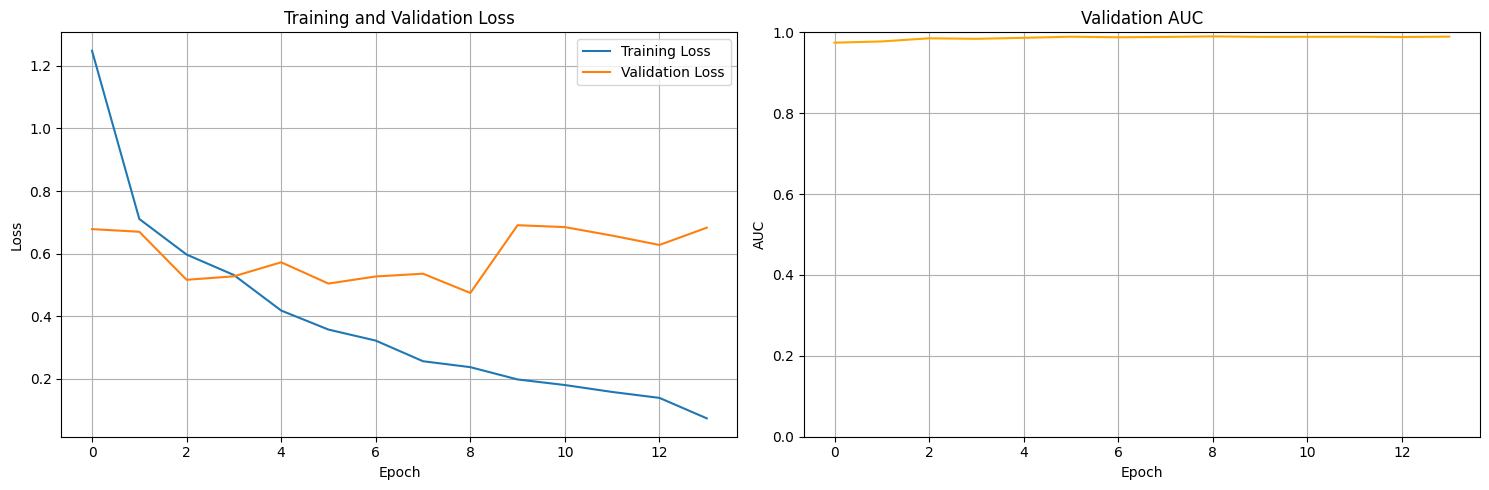


--- Evaluating MobileViTV2 Model ---


Testing: 100%|██████████| 615/615 [00:10<00:00, 59.64it/s]



--- Evaluation Metrics ---
AUC Score: 0.9365

Confusion Matrix:
[[18428  1027]
 [   47   148]]

Classification Report:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.95      0.97     19455
        Lens       0.13      0.76      0.22       195

    accuracy                           0.95     19650
   macro avg       0.56      0.85      0.59     19650
weighted avg       0.99      0.95      0.96     19650



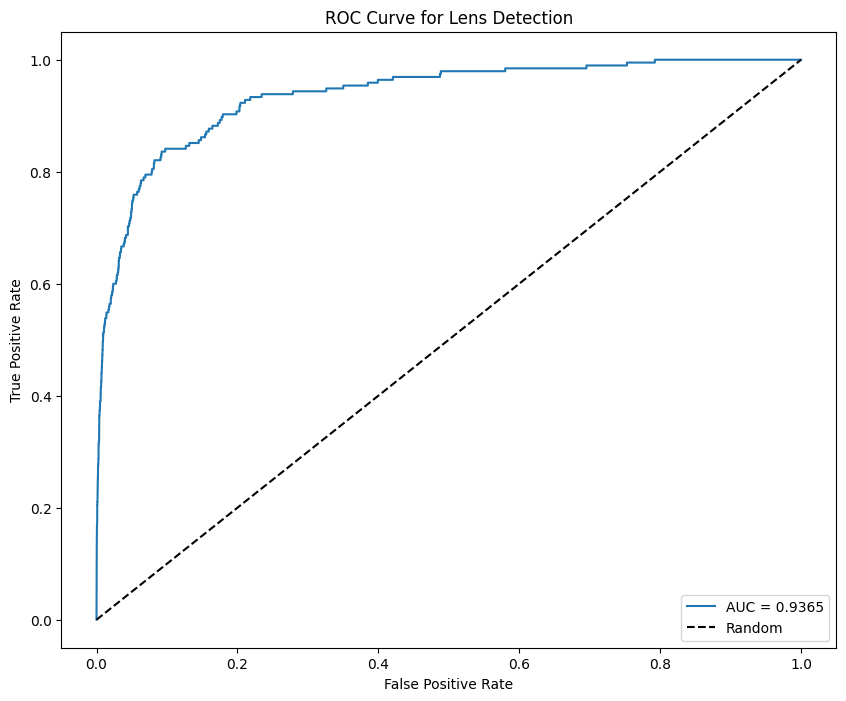

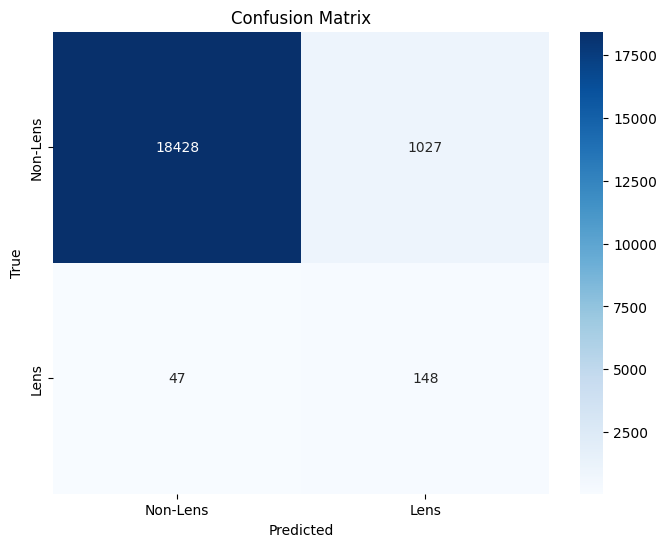


--- Optimal Threshold Analysis ---
Optimal Threshold: 0.0880

Confusion Matrix with Optimal Threshold:
[[17558  1897]
 [   31   164]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.90      0.95     19455
        Lens       0.08      0.84      0.15       195

    accuracy                           0.90     19650
   macro avg       0.54      0.87      0.55     19650
weighted avg       0.99      0.90      0.94     19650



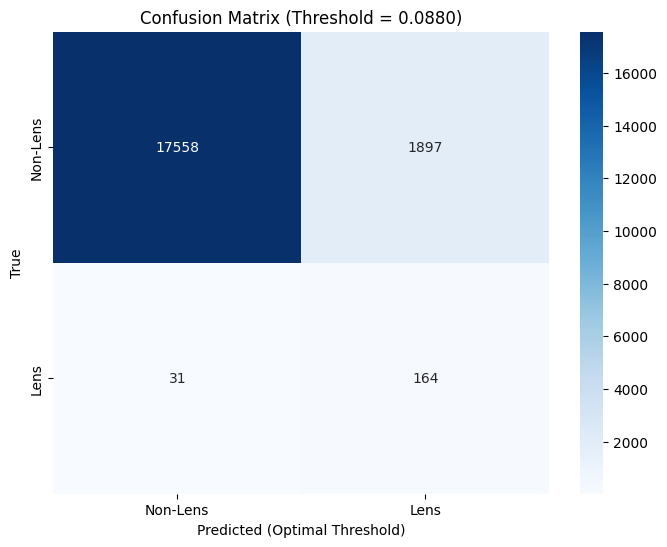


--- Creating and Evaluating Ensemble Model (EfficientNet-B1 + EfficientNet-B2) ---

--- Evaluating Ensemble Model ---


Testing: 100%|██████████| 615/615 [00:21<00:00, 28.48it/s]



--- Evaluation Metrics ---
AUC Score: 0.9504

Confusion Matrix:
[[18392  1063]
 [   52   143]]

Classification Report:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.95      0.97     19455
        Lens       0.12      0.73      0.20       195

    accuracy                           0.94     19650
   macro avg       0.56      0.84      0.59     19650
weighted avg       0.99      0.94      0.96     19650



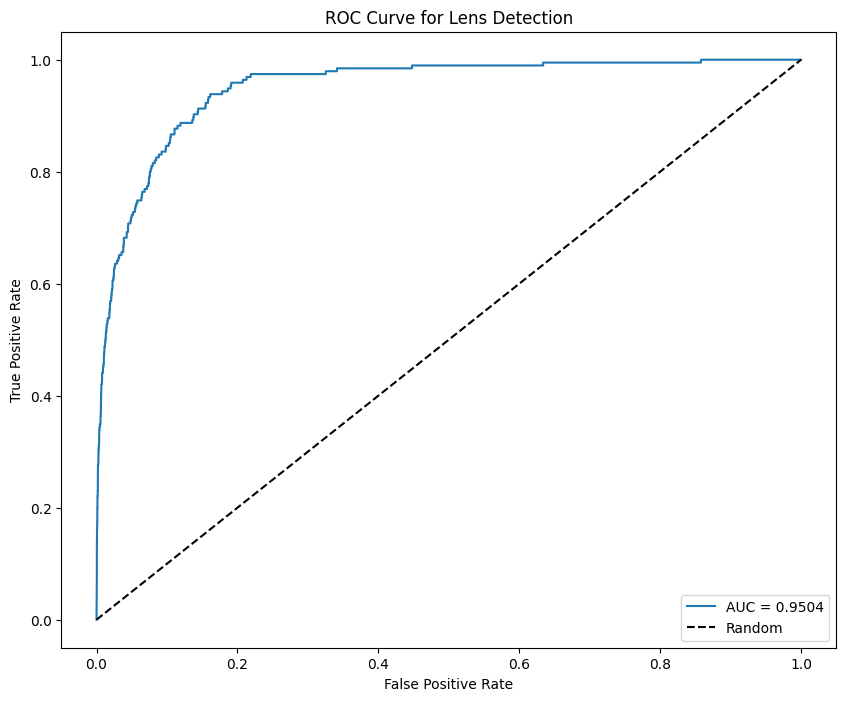

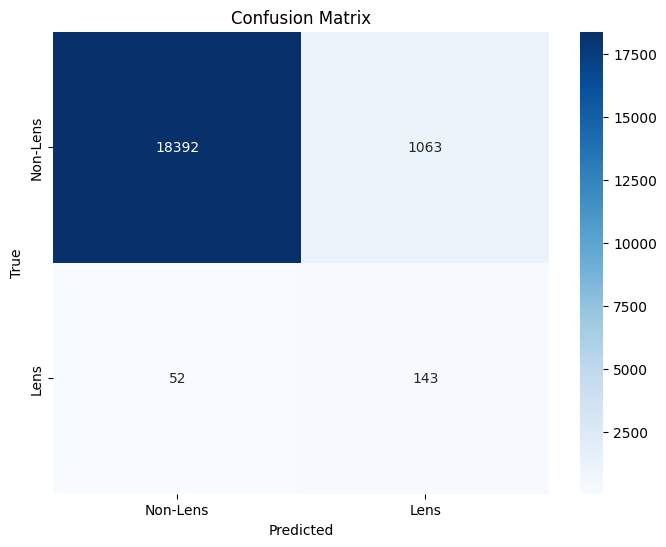


--- Optimal Threshold Analysis ---
Optimal Threshold: 0.0310

Confusion Matrix with Optimal Threshold:
[[16315  3140]
 [   12   183]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

    Non-Lens       1.00      0.84      0.91     19455
        Lens       0.06      0.94      0.10       195

    accuracy                           0.84     19650
   macro avg       0.53      0.89      0.51     19650
weighted avg       0.99      0.84      0.90     19650



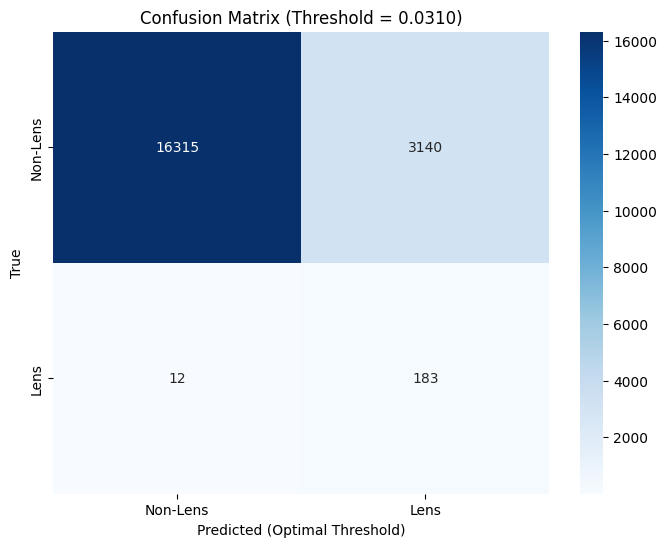


--- Model Comparison ---
             Model       AUC  F1 Score  Precision    Recall
2         resnet18  0.981768  0.209577   0.117722  0.953846
4         ensemble  0.950450  0.104036   0.055071  0.938462
0  efficientnet_b1  0.942142  0.121646   0.065385  0.871795
3        mobilevit  0.936533  0.145390   0.079573  0.841026
1  efficientnet_b2  0.935039  0.087539   0.045911  0.938462


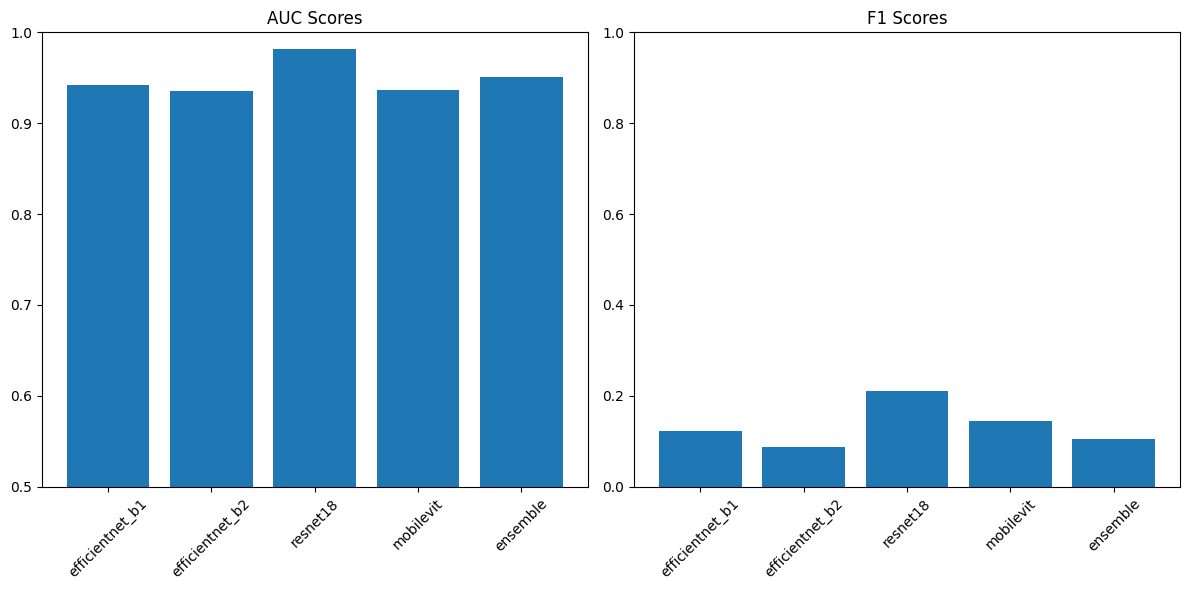


--- Best Model: resnet18 ---
AUC Score: 0.9818
Optimal Threshold: 0.0021
Lens Precision: 0.1177
Lens Recall: 0.9538
Lens F1 Score: 0.2096


In [10]:
def main():
    """Main function to run the entire pipeline."""
    # Set hyperparameters
    batch_size = 32
    num_epochs = 15
    learning_rate = 1e-4
    weight_decay = 1e-4
    patience = 5
    val_split = 0.1
    model_type = 'all'  
    
    # Get dataset size for calculating pos_weight (using original dataset sizes)
    train_lens_count = count_files(train_lens_dir)
    train_nonlens_count = count_files(train_nonlens_dir)
    
    # Calculate positive class weight for BCEWithLogitsLoss and move to device
    pos_weight = torch.tensor([train_nonlens_count / train_lens_count]).to(device)
    print(f"Using positive class weight: {pos_weight.item():.4f}")
    
    # Process data and get normalization statistics
    processed_lens_dir, processed_nonlens_dir, means, stds = preprocess_data_and_get_statistics(
        train_lens_dir=train_lens_dir,
        train_nonlens_dir=train_nonlens_dir,
        augment_factor=10, 
        output_dir='processed_data',
        seed=42
    )

    # Create the datasets with proper normalization
    train_dataset, val_dataset, test_dataset = create_datasets(
        processed_lens_dir=processed_lens_dir,
        processed_nonlens_dir=processed_nonlens_dir,
        test_lens_dir=test_lens_dir,
        test_nonlens_dir=test_nonlens_dir,
        means=means,
        stds=stds,
        val_split=0.1
    )
    
    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        batch_size=batch_size,
        num_workers=4
    )
    
    # Set up results directory
    results_dir = 'lens_detection_results'
    os.makedirs(results_dir, exist_ok=True)
    
    # Dictionary to store trained models and their metrics
    trained_models = {}
    metrics_dict = {}
    
    # Train and evaluate EfficientNet-B1
    if model_type in ['efficientnet_b1', 'ensemble', 'all']:
        print("\n--- Training EfficientNet-B1 Model ---")
        efficientnet_b1_model = EfficientNetB1Model().to(device)
        efficientnet_b1_save_path = os.path.join(results_dir, 'best_efficientnet_b1_model.pth')
        
        efficientnet_b1_optimizer = torch.optim.AdamW(
            efficientnet_b1_model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        efficientnet_b1_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            efficientnet_b1_optimizer, 
            mode='min', 
            factor=0.1, 
            patience=3, 
            verbose=True
        )
        
        efficientnet_b1_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        efficientnet_b1_history = train_model(
            model=efficientnet_b1_model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=efficientnet_b1_criterion,
            optimizer=efficientnet_b1_optimizer,
            scheduler=efficientnet_b1_scheduler,
            num_epochs=num_epochs,
            patience=patience,
            save_path=efficientnet_b1_save_path
        )
        
        visualize_training_history(
            efficientnet_b1_history, 
            plots_dir=os.path.join(results_dir, 'efficientnet_b1_plots')
        )
        
        print("\n--- Evaluating EfficientNet-B1 Model ---")
        efficientnet_b1_metrics = evaluate_model(
            model=efficientnet_b1_model,
            test_loader=test_loader,
            save_plots=True,
            plots_dir=os.path.join(results_dir, 'efficientnet_b1_plots')
        )
        
        trained_models['efficientnet_b1'] = efficientnet_b1_model
        metrics_dict['efficientnet_b1'] = efficientnet_b1_metrics
    
    # Train and evaluate EfficientNet-B2
    if model_type in ['efficientnet_b2', 'ensemble', 'all']:
        print("\n--- Training EfficientNet-B2 Model ---")
        efficientnet_b2_model = EfficientNetB2Model().to(device)
        efficientnet_b2_save_path = os.path.join(results_dir, 'best_efficientnet_b2_model.pth')
        
        efficientnet_b2_optimizer = torch.optim.AdamW(
            efficientnet_b2_model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        efficientnet_b2_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            efficientnet_b2_optimizer, 
            mode='min', 
            factor=0.1, 
            patience=3, 
            verbose=True
        )
        
        efficientnet_b2_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        efficientnet_b2_history = train_model(
            model=efficientnet_b2_model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=efficientnet_b2_criterion,
            optimizer=efficientnet_b2_optimizer,
            scheduler=efficientnet_b2_scheduler,
            num_epochs=num_epochs,
            patience=patience,
            save_path=efficientnet_b2_save_path
        )
        
        visualize_training_history(
            efficientnet_b2_history, 
            plots_dir=os.path.join(results_dir, 'efficientnet_b2_plots')
        )
        
        print("\n--- Evaluating EfficientNet-B2 Model ---")
        efficientnet_b2_metrics = evaluate_model(
            model=efficientnet_b2_model,
            test_loader=test_loader,
            save_plots=True,
            plots_dir=os.path.join(results_dir, 'efficientnet_b2_plots')
        )
        
        trained_models['efficientnet_b2'] = efficientnet_b2_model
        metrics_dict['efficientnet_b2'] = efficientnet_b2_metrics
    
    # Train and evaluate ResNet18
    if model_type in ['resnet18', 'all']:
        print("\n--- Training ResNet18 Model ---")
        resnet18_model = ResNet18Model().to(device)
        resnet18_save_path = os.path.join(results_dir, 'best_resnet18_model.pth')
        
        resnet18_optimizer = torch.optim.AdamW(
            resnet18_model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        resnet18_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            resnet18_optimizer, 
            mode='min', 
            factor=0.1, 
            patience=3, 
            verbose=True
        )
        
        resnet18_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        resnet18_history = train_model(
            model=resnet18_model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=resnet18_criterion,
            optimizer=resnet18_optimizer,
            scheduler=resnet18_scheduler,
            num_epochs=num_epochs,
            patience=patience,
            save_path=resnet18_save_path
        )
        
        visualize_training_history(
            resnet18_history, 
            plots_dir=os.path.join(results_dir, 'resnet18_plots')
        )
        
        print("\n--- Evaluating ResNet18 Model ---")
        resnet18_metrics = evaluate_model(
            model=resnet18_model,
            test_loader=test_loader,
            save_plots=True,
            plots_dir=os.path.join(results_dir, 'resnet18_plots')
        )
        
        trained_models['resnet18'] = resnet18_model
        metrics_dict['resnet18'] = resnet18_metrics
    
    # Train and evaluate MobileViTV2
    if model_type in ['mobilevit', 'all']:
        print("\n--- Training MobileViTV2 Model ---")
        mobilevit_model = MobileViTV2Model().to(device)
        mobilevit_save_path = os.path.join(results_dir, 'best_mobilevit_model.pth')
        
        mobilevit_optimizer = torch.optim.AdamW(
            mobilevit_model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        mobilevit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            mobilevit_optimizer, 
            mode='min', 
            factor=0.1, 
            patience=3, 
            verbose=True
        )
        
        mobilevit_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        mobilevit_history = train_model(
            model=mobilevit_model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=mobilevit_criterion,
            optimizer=mobilevit_optimizer,
            scheduler=mobilevit_scheduler,
            num_epochs=num_epochs,
            patience=patience,
            save_path=mobilevit_save_path
        )
        
        visualize_training_history(
            mobilevit_history, 
            plots_dir=os.path.join(results_dir, 'mobilevit_plots')
        )
        
        print("\n--- Evaluating MobileViTV2 Model ---")
        mobilevit_metrics = evaluate_model(
            model=mobilevit_model,
            test_loader=test_loader,
            save_plots=True,
            plots_dir=os.path.join(results_dir, 'mobilevit_plots')
        )
        
        trained_models['mobilevit'] = mobilevit_model
        metrics_dict['mobilevit'] = mobilevit_metrics
    
    # Evaluate Ensemble model (EfficientNet-B1 + EfficientNet-B2)
    if model_type in ['ensemble', 'all'] and 'efficientnet_b1' in trained_models and 'efficientnet_b2' in trained_models:
        print("\n--- Creating and Evaluating Ensemble Model (EfficientNet-B1 + EfficientNet-B2) ---")
        
        # Create ensemble from trained models
        ensemble_model = EnsembleModel([
            trained_models['efficientnet_b1'],
            trained_models['efficientnet_b2']
        ]).to(device)
        
        print("\n--- Evaluating Ensemble Model ---")
        ensemble_metrics = evaluate_model(
            model=ensemble_model,
            test_loader=test_loader,
            save_plots=True,
            plots_dir=os.path.join(results_dir, 'ensemble_plots')
        )
        
        trained_models['ensemble'] = ensemble_model
        metrics_dict['ensemble'] = ensemble_metrics
    
    # Model comparison
    if len(metrics_dict) > 1:
        print("\n--- Model Comparison ---")
        model_names = []
        auc_scores = []
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        for model_name, metrics in metrics_dict.items():
            model_names.append(model_name)
            auc_scores.append(metrics['auc'])
            f1_scores.append(metrics['optimal_classification_report']['Lens']['f1-score'])
            precision_scores.append(metrics['optimal_classification_report']['Lens']['precision'])
            recall_scores.append(metrics['optimal_classification_report']['Lens']['recall'])
        
        # Create comparison table
        comparison_df = pd.DataFrame({
            'Model': model_names,
            'AUC': auc_scores,
            'F1 Score': f1_scores,
            'Precision': precision_scores,
            'Recall': recall_scores
        })
        
        print(comparison_df.sort_values('AUC', ascending=False))
        
        # Save comparison to CSV
        comparison_df.to_csv(os.path.join(results_dir, 'model_comparison.csv'), index=False)
        
        # Visualize comparison
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(model_names, auc_scores)
        plt.title('AUC Scores')
        plt.xticks(rotation=45)
        plt.ylim(0.5, 1.0)
        
        plt.subplot(1, 2, 2)
        plt.bar(model_names, f1_scores)
        plt.title('F1 Scores')
        plt.xticks(rotation=45)
        plt.ylim(0, 1.0)
        
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, 'model_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # Find best model based on AUC score
    if metrics_dict:
        best_model_name = max(metrics_dict, key=lambda k: metrics_dict[k]['auc'])
        best_model = trained_models[best_model_name]
        best_metrics = metrics_dict[best_model_name]
        
        print(f"\n--- Best Model: {best_model_name} ---")
        print(f"AUC Score: {best_metrics['auc']:.4f}")
        print(f"Optimal Threshold: {best_metrics['optimal_threshold']:.4f}")
        
        # Print detailed lens detection metrics
        lens_precision = best_metrics['optimal_classification_report']['Lens']['precision']
        lens_recall = best_metrics['optimal_classification_report']['Lens']['recall']
        lens_f1 = best_metrics['optimal_classification_report']['Lens']['f1-score']
        
        print(f"Lens Precision: {lens_precision:.4f}")
        print(f"Lens Recall: {lens_recall:.4f}")
        print(f"Lens F1 Score: {lens_f1:.4f}")
        
        # Save final results summary
        with open(os.path.join(results_dir, 'best_model_summary.txt'), 'w') as f:
            f.write(f"Best Model: {best_model_name}\n")
            f.write(f"AUC Score: {best_metrics['auc']:.4f}\n")
            f.write(f"Optimal Threshold: {best_metrics['optimal_threshold']:.4f}\n")
            f.write(f"Lens Precision: {lens_precision:.4f}\n")
            f.write(f"Lens Recall: {lens_recall:.4f}\n")
            f.write(f"Lens F1 Score: {lens_f1:.4f}\n")
        
        return best_model, best_metrics
    
    return None, None

# Execute the main function
if __name__ == "__main__":
    best_model, best_metrics = main()
